In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import shutil

import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import tensorflow as tf

# Import packages for data handling
import h5py
from PIL import Image
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

# Import deep learning package (tensorflow)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, Reshape, Bidirectional, LSTM, Dense,Activation, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

color = sns.color_palette()
%matplotlib inline

# Set seed nunmber to all packages
seed_number = 24
np.random.seed(seed_number)
tf.random.set_seed(seed_number)


Configuring directories

In [2]:
root = "../input/lcc-fasd"
input_dir = os.path.join(root,"LCC_FASD")
train_dir = os.path.join(input_dir, 'LCC_FASD_training')
val_dir = os.path.join(input_dir, 'LCC_FASD_development')
test_dir = os.path.join(input_dir, 'LCC_FASD_evaluation')

dataset_dir = sorted(next(os.walk(input_dir))[1])

label_name = sorted(next(os.walk(train_dir))[1])

# Observing the Dataset
Grasping some of the dataset information

In [3]:
dir_dict = {'train': train_dir, 'val': val_dir, 'test': test_dir}
case_count, img_disp, set_length  = {}, {}, {}

for key, val in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0
    
    for label in label_name:
        label_list = list(sorted(glob.glob(os.path.join(val, label, "*.png"))))
        if len(label_list) == 0:
          continue

        case_count[key][label] = len(label_list)
        set_count += len(label_list)
        
        select_img_id = np.random.randint(len(label_list)-1)
        # print(select_img_id)
        img_disp[key][label] = label_list[select_img_id]
        
    set_length[key] = set_count

case_count_df = pd.DataFrame(case_count)
img_disp_df = pd.DataFrame(img_disp)
print(f"Dataset summary:\n\n{case_count_df}")

Dataset summary:

       train   val  test
real    1223   405   314
spoof   7076  2543  7266


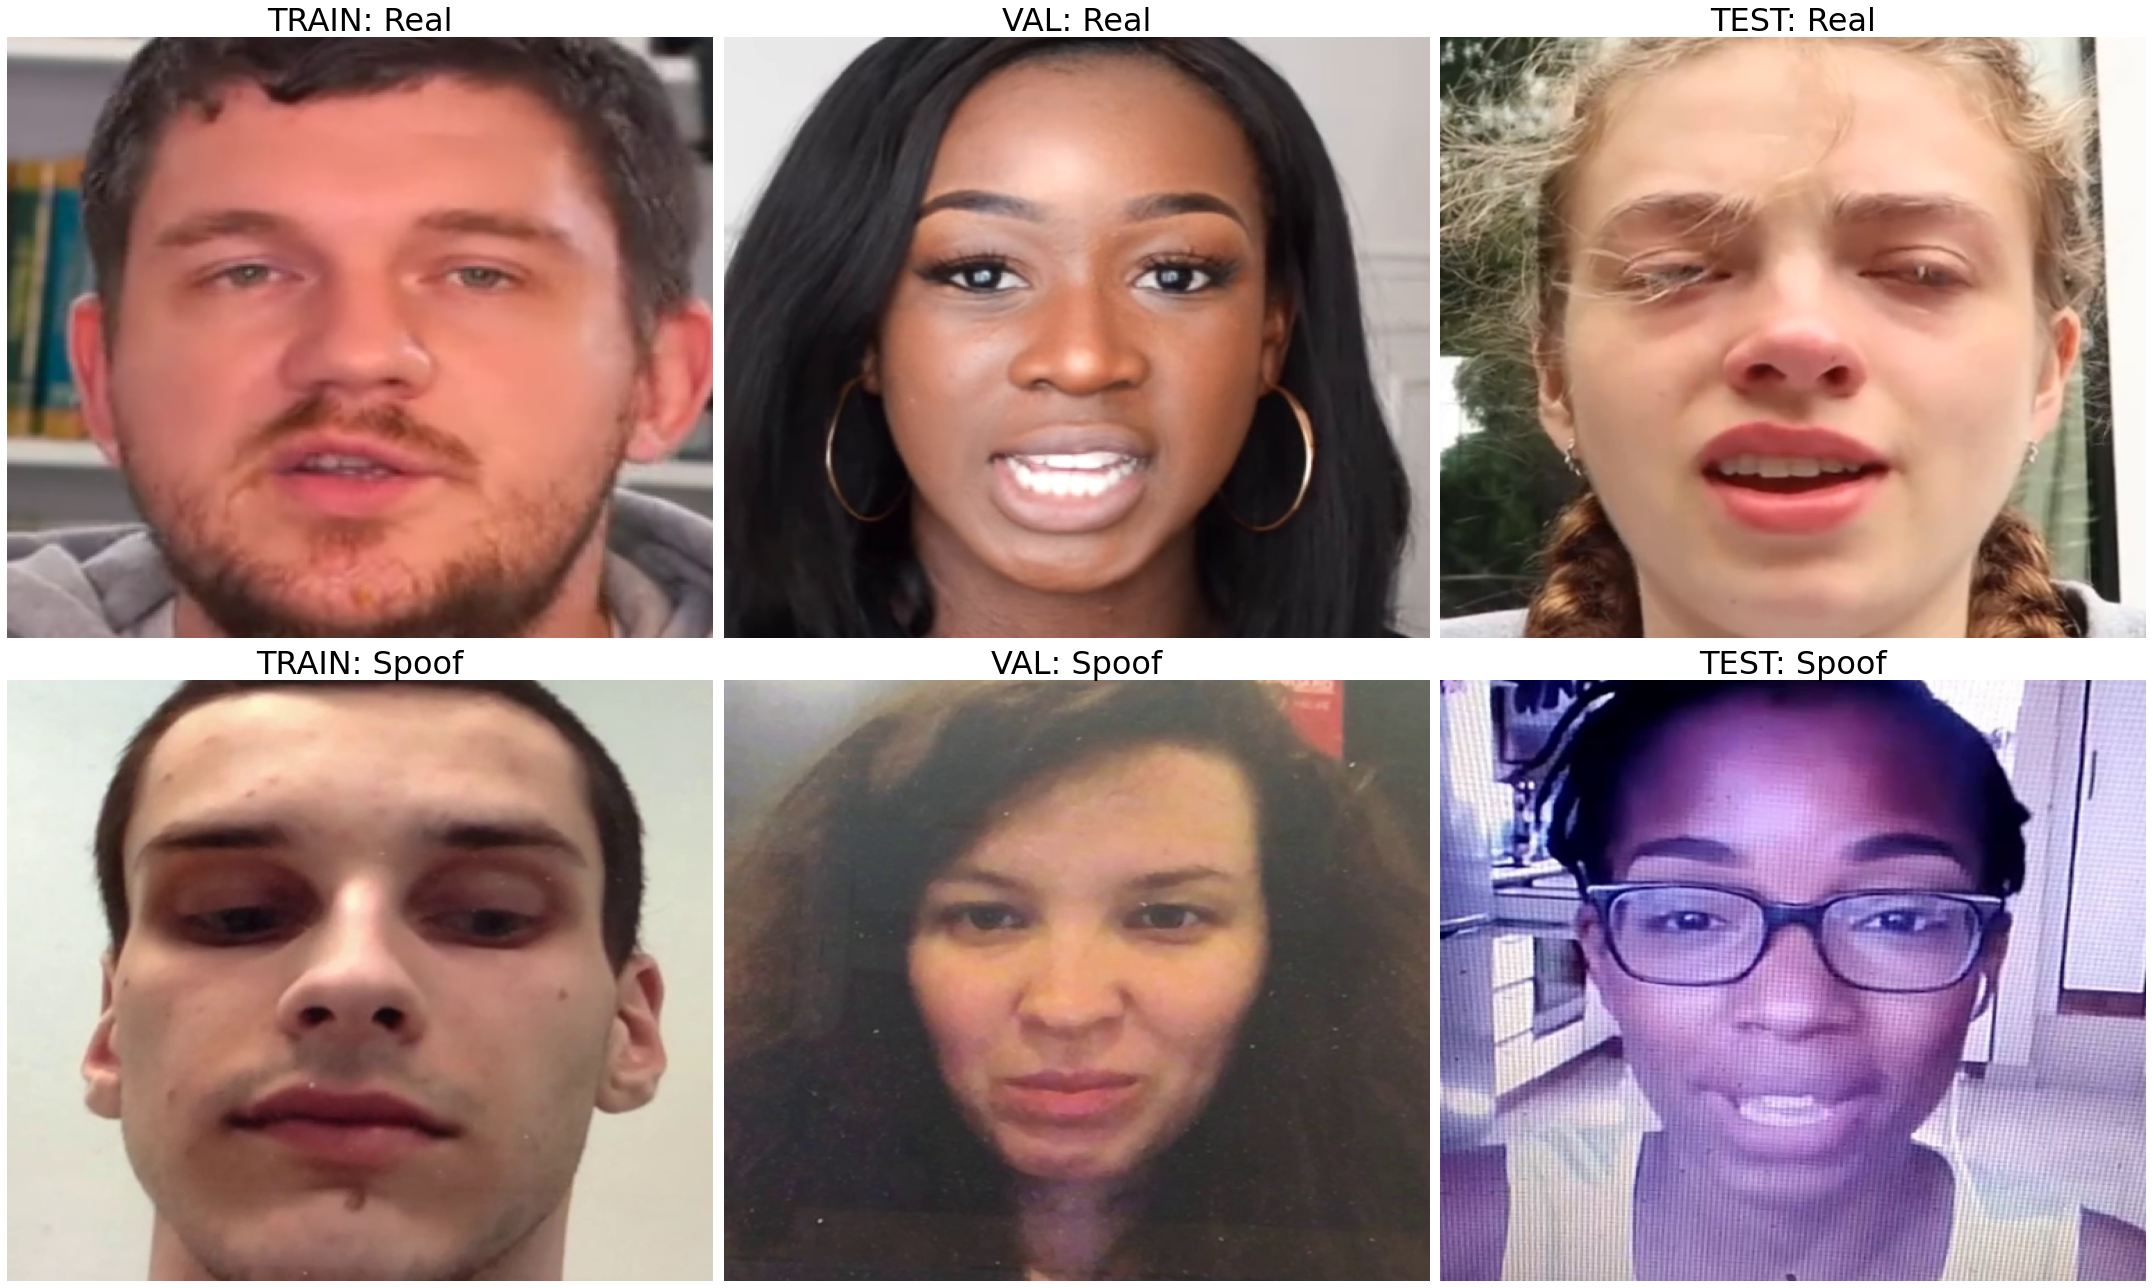

In [4]:
num_classes = len(label_name)
num_dataset = 0
for key, val in set_length.items():
  num_dataset += 1 if val > 0 else 0

fig, ax = plt.subplots(num_classes, num_dataset, figsize=(num_dataset*10, 18))

for k in range(num_classes*num_dataset):
    j, i = k // num_dataset, k % num_dataset  # Image indexing
    
    img = imread(img_disp_df.iloc[j, i])
    ax[j, i].imshow(img, cmap='gray')
    ax[j, i].set_title(f"{img_disp_df.columns[i].upper()}: {img_disp_df.index[j].capitalize()}", fontsize=32)
    ax[j, i].axis('off')
    ax[j, i].set_aspect('auto')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Dataset Problem
Instantiate dataset object for training procedure (e.g., train, val, and test)

In [5]:
datagen_params = {
    "rescale": 1./255,
}

# Augmentation parameters for training data generator
train_augmentation_params = {
    "rotation_range": 20,
    "width_shift_range": 0.2,
    "height_shift_range": 0.2,
    "shear_range": 0.15,
    "zoom_range": 0.15,
    "horizontal_flip": True,
    "fill_mode": "nearest"
}

In [6]:
train_datagen = ImageDataGenerator(**datagen_params, **train_augmentation_params)
val_datagen = ImageDataGenerator(**datagen_params)
test_datagen = ImageDataGenerator(**datagen_params) if set_length["test"] > 0 else None


In [7]:
# Define dataset properties
batch_size = 32
img_width = 224
img_height = 224

# Generate dataset for train, val and test
train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size = batch_size,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number)

val_gen = val_datagen.flow_from_directory(val_dir,
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          target_size = (img_width, img_height),
                                          seed = seed_number)

if test_datagen is not None:
  test_gen = test_datagen.flow_from_directory(test_dir,
                                              batch_size = 1,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number,
                                              shuffle=False)
else:
  test_gen = None

Found 8299 images belonging to 2 classes.
Found 2948 images belonging to 2 classes.
Found 7580 images belonging to 2 classes.


# Generate Model
Using a pre-trained MobileNet-v2 model, provided by tensorflow

In [8]:
# Don't forget to turn on the Internet to download the respective pre-trained weights!
pretrain_net = mobilenet_v2.MobileNetV2(input_shape = (img_width, img_height, 3),
                                        include_top = False,
                                        weights = 'imagenet')

freeze_before_layer = "block_16_expand"

freeze_index = None if freeze_before_layer is None else [layer.name for layer in pretrain_net.layers].index(freeze_before_layer)

for layer in pretrain_net.layers[:freeze_index]:
    layer.trainable = False


9412608/9406464 [==============================] - 1s 0us/step


In [9]:
# Adding extra layer for our problem
#x = pretrain_net.output
#x = Conv2D(32, (3, 3), activation='relu')(x)
#x = Dropout(rate=0.2, name='extra_dropout1')(x)
#x = GlobalAveragePooling2D()(x)
#x = Dense(1, activation='sigmoid', name='classifier')(x)

#model = Model(inputs=pretrain_net.input, outputs=x, name='mobilenetv2_spoof')
#print(model.summary())


x = pretrain_net.output
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Dropout(rate=0.2, name='extra_dropout1')(x)
x = GlobalAveragePooling2D()(x)

# Reshape the output to a suitable format for feeding into an RNN
x = Reshape((-1, 32))(x)

# Add LSTM layers
x = Bidirectional(LSTM(128, return_sequences=True), name='lstm1')(x)
x = LSTM(128, return_sequences=False, name='lstm2')(x)

# Add a Dense layer for classification
x = Dense(1, activation='sigmoid', name='classifier')(x)

# Define the model
model = Model(inputs=pretrain_net.input, outputs=x, name='mobilenetv2_spoof')

# Print the summary of the model
print(model.summary())
# Notice: Unhide the OUTPUT!

Model: "mobilenetv2_spoof"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________

In [10]:
x.shape

TensorShape([None, 1])

# Perform Training
Define the training procedure

In [11]:
train_id = "lcc-train04b-weight_all"  # ID of the training procedure
num_epochs = 15  # Set the number of epochs to train
learning_rate = 5e-5  # Set the learning rate to use

model.compile(optimizer = Adam(lr=learning_rate),
              loss = 'binary_crossentropy',
              metrics = ['acc'])




In [12]:
train_length = len(train_gen.classes)
class_weights = {}

for i in range(len(label_name)):
    class_weights[i] = train_length / case_count_df['train'][label_name[i]] / len(label_name)

# Train your model using class weights

Start training!

In [13]:
history = model.fit(train_gen,
                    epochs = num_epochs,
                    
                    validation_data = val_gen,
                    validation_steps = 1,
                    
                    class_weight=class_weights)


Epoch 1/15
260/260 [==============================] - 287s 1s/step - loss: 0.4909 - acc: 0.8267 - val_loss: 0.1689 - val_acc: 0.9375
Epoch 2/15
260/260 [==============================] - 207s 796ms/step - loss: 0.2947 - acc: 0.8760 - val_loss: 0.2418 - val_acc: 0.9062
Epoch 3/15
260/260 [==============================] - 206s 793ms/step - loss: 0.2405 - acc: 0.9024 - val_loss: 0.3821 - val_acc: 0.8125
Epoch 4/15
260/260 [==============================] - 209s 804ms/step - loss: 0.2080 - acc: 0.9129 - val_loss: 0.1514 - val_acc: 0.9688
Epoch 5/15
260/260 [==============================] - 206s 792ms/step - loss: 0.1812 - acc: 0.9237 - val_loss: 0.2247 - val_acc: 0.8438
Epoch 6/15
260/260 [==============================] - 208s 798ms/step - loss: 0.1665 - acc: 0.9304 - val_loss: 0.1669 - val_acc: 0.9688
Epoch 7/15
260/260 [==============================] - 211s 811ms/step - loss: 0.1508 - acc: 0.9391 - val_loss: 0.3168 - val_acc: 0.8750
Epoch 8/15
260/260 [==============================]

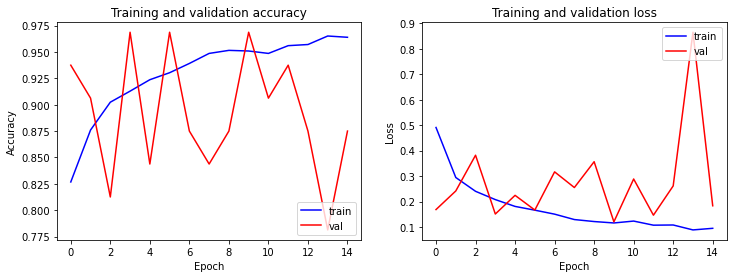

In [14]:
# Plotting the train results
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

# Results evaluation
Use this section to evaluate the model performance on the Test set.

In [15]:
# Test set accuracy and loss
test_scores = model.evaluate(test_gen, steps=set_length['test'])
print("Test results Accuracy: {0:.2f}% and Loss: {0:.2f}".format(test_scores[1]*100, test_scores[0]))

# Calculate prediction
threshold = 0.5  # Define the sigmoid threshold for True or False
y_pred_value = np.squeeze(model.predict(test_gen, steps=set_length['test'], verbose=1))

y_pred = np.zeros(y_pred_value.shape).astype(np.int32)  # Sigmoid
y_pred[y_pred_value > threshold] = 1

# y_pred = np.argmax(y_pred_value, axis=-1).astype(np.int32)  # Softmax

y_true = test_gen.classes

# Sanity check on the y_pred and y_true value
print(f"Label\t\t: {y_true[:10]}")
print(f"Prediction\t: {y_pred[:10]}")

7580/7580 [==============================] - 179s 24ms/step - loss: 0.3334 - acc: 0.9113
Test results Accuracy: 91.13% and Loss: 91.13
7580/7580 [==============================] - 119s 16ms/step
Label		: [0 0 0 0 0 0 0 0 0 0]
Prediction	: [1 1 0 0 0 0 0 0 0 0]


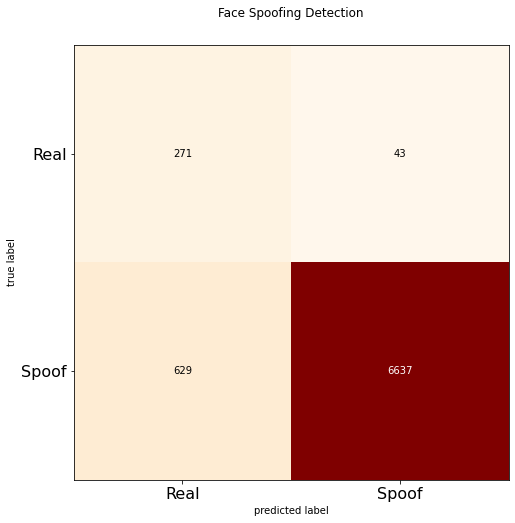

Report Summary:
Precision	: 99.36%
Recall		: 91.34%
F1 Score	: 95.18%

Notes: 
True labels	: Spoof
False labels	: Real


In [16]:
# Confusion matrix result
confusion_matrix_result = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_matrix_result,
                      figsize=(12,8),
                      hide_ticks=True,
                      cmap="OrRd")
plt.title("Face Spoofing Detection")
plt.xticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.yticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.show()

# Precision and Recall metrics
tn, fp, fn, tp = confusion_matrix_result.ravel()
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1_score = 2 * precision * recall / (precision+recall)

print("Report Summary:")
print("Precision\t: {:.2f}%".format(precision*100))
print("Recall\t\t: {:.2f}%".format(recall*100))
print("F1 Score\t: {:.2f}%".format(f1_score*100))

print("\nNotes: ")
print("True labels\t: Spoof")
print("False labels\t: Real")


In [17]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [18]:
with open("model3.tflite","wb") as f:
    f.write(tflite_model)